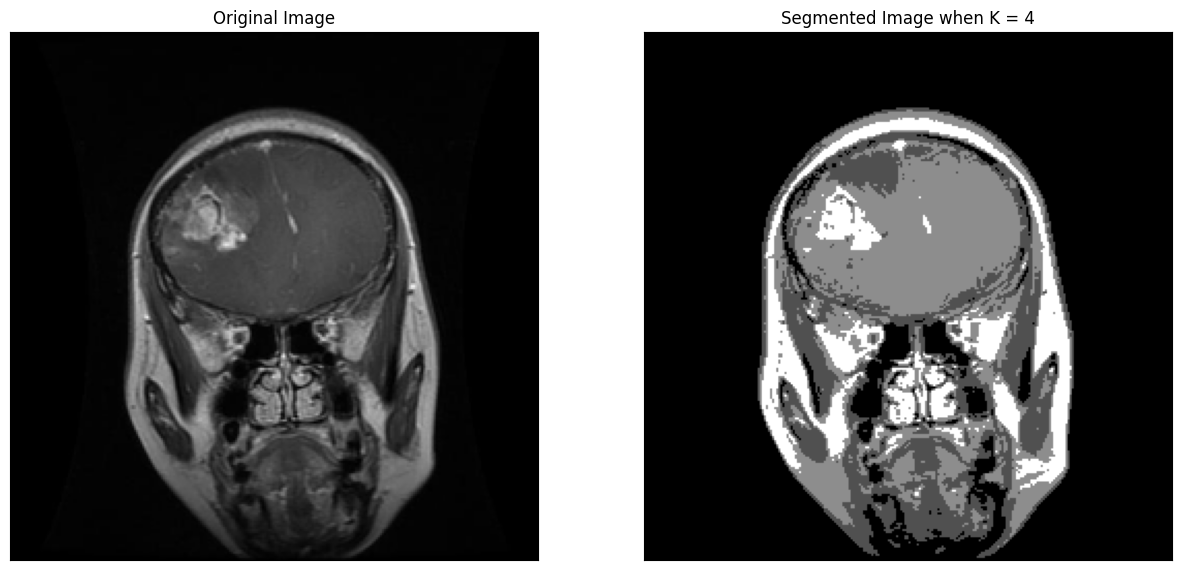

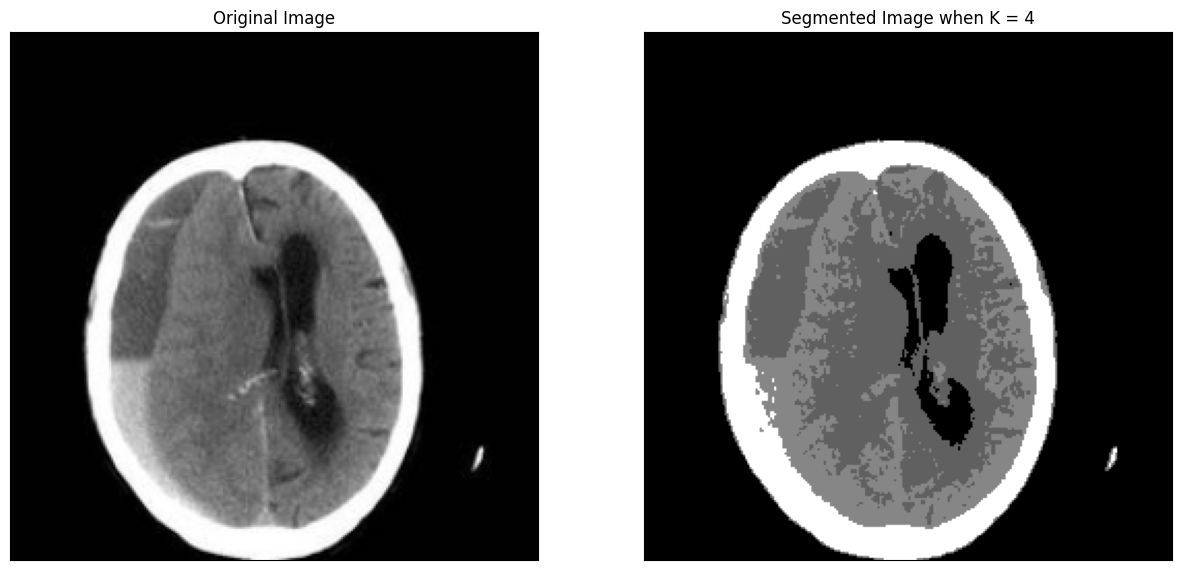

In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras as keras
from keras.layers import Input, Lambda, Dense, Flatten,Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pandas as pd
import os
import cv2
import random


def segment_image(image):
    # konwersja obrazu na skalę szarości
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    # przekształcenie macierzy pikseli na wektor
    vectorized = gray.reshape((-1, 1))
    vectorized = np.float32(vectorized)
    # ustawienie kryteriów zatrzymania algorytmu k-średnich.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 4
    attempts = 20
    # wykonanie algorytmu k-średnich na wektorze pikseli
    ret, label, center = cv2.kmeans(vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    # konwersja wartości środków klastrów na typ uint8
    center = np.uint8(center)
    # przypisanie każdemu pikselowi wartości środka klastra, do którego należy
    res = center[label.flatten()]
    # przekształcenie wektora wynikowego z powrotem na macierz o wymiarach obrazu wejściowego
    result_image = res.reshape(gray.shape)

    return result_image



# Plot the results
img = cv2.imread('bt_dataset/train/glioma/Tr-glTr_0000.jpg')
img=cv2.resize(img,(256,256))
result_image = segment_image(img)
figure_size = 15
plt.figure(figsize=(figure_size, figure_size))
plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2), plt.imshow(result_image, cmap='gray')
plt.title('Segmented Image when K = %i' % 4), plt.xticks([]), plt.yticks([])
plt.show()

# Plot the results
img = cv2.imread('bt_dataset/test/notumor/Te-noTr_0000.jpg')
img=cv2.resize(img,(256,256))
result_image = segment_image(img)
figure_size = 15
plt.figure(figsize=(figure_size, figure_size))
plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2), plt.imshow(result_image, cmap='gray')
plt.title('Segmented Image when K = %i' % 4), plt.xticks([]), plt.yticks([])
plt.show()

Ładowanie danych

In [2]:
train_path="bt_dataset/train"
test_path="bt_dataset/test"
val_path="bt_dataset/valid"
x_train=[]
y_train = []

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(256,256))
        img_arr=segment_image(img_arr)
        x_train.append(img_arr)
        if folder == 'glioma':
            y_train.append(1)
        elif folder == 'meningioma':
            y_train.append(2)
        elif folder == 'pituitary':
            y_train.append(3)
        elif folder == 'notumor':
            y_train.append(0)


x_test=[]
y_test = []

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(256,256))
        img_arr=segment_image(img_arr)
        x_test.append(img_arr)
        if folder == 'glioma':
            y_test.append(1)
        elif folder == 'meningioma':
            y_test.append(2)
        elif folder == 'pituitary':
            y_test.append(3)
        elif folder == 'notumor':
            y_test.append(0)

x_val=[]
y_val = []

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(256,256))
        img_arr=segment_image(img_arr)
        x_val.append(img_arr)
        if folder == 'glioma':
            y_val.append(1)
        elif folder == 'meningioma':
            y_val.append(2)
        elif folder == 'pituitary':
            y_val.append(3)
        elif folder == 'notumor':
            y_val.append(0)

print("x_train = " , len(x_train))
print("y_train = " , len(y_train))
print("x_test = " , len(x_test))
print("y_test = " , len(y_test))
print("x_val = " , len(x_val))
print("y_val = " , len(y_val))

x_train =  4150
y_train =  4150
x_test =  1311
y_test =  1311
x_val =  1562
y_val =  1562


Przygotowanie danych

In [3]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
# normalizacja danych
x_train = np.array(x_train)
x_train = x_train.astype('float32') / 255.0

x_test = np.array(x_test)
x_test = x_test.astype('float32') / 255.0

x_val = np.array(x_val)
x_val = x_val.astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

# dostosowanie do rozmiaru wejsciowego sieci neuronowej
x_train = x_train.reshape(x_train.shape[0], 256, 256, 1)
x_test = x_test.reshape(x_test.shape[0], 256, 256, 1)
x_val = x_val.reshape(x_val.shape[0], 256, 256, 1)

Implementacja CNN

In [9]:
# IMPLEMENTACJA CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Kompilacja modelu przy uzyciu optimizera Adam
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Ustawienie unkcje wywołań zwrotnych
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=0.000005)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Trening modelu
batch_size = 32
epochs = 100
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch=(len(x_train) // batch_size) + 1,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stop])

Epoch 1/100
130/130 [==============================] - 8s 59ms/step - loss: 0.6706 - accuracy: 0.7564 - val_loss: 5.7768 - val_accuracy: 0.2606 - lr: 5.0000e-04
Epoch 2/100
130/130 [==============================] - 6s 50ms/step - loss: 0.4580 - accuracy: 0.8308 - val_loss: 2.8932 - val_accuracy: 0.4008 - lr: 5.0000e-04
Epoch 3/100
130/130 [==============================] - 7s 55ms/step - loss: 0.2916 - accuracy: 0.8954 - val_loss: 2.6421 - val_accuracy: 0.3816 - lr: 5.0000e-04
Epoch 4/100
130/130 [==============================] - 7s 55ms/step - loss: 0.1936 - accuracy: 0.9296 - val_loss: 1.3843 - val_accuracy: 0.5864 - lr: 5.0000e-04
Epoch 5/100
130/130 [==============================] - 7s 55ms/step - loss: 0.1364 - accuracy: 0.9557 - val_loss: 0.7109 - val_accuracy: 0.7932 - lr: 5.0000e-04
Epoch 6/100
130/130 [==============================] - 7s 56ms/step - loss: 0.0785 - accuracy: 0.9740 - val_loss: 0.6523 - val_accuracy: 0.8220 - lr: 5.0000e-04
Epoch 7/100
130/130 [=============

Test modelu

In [10]:
loss, acc = model.evaluate(x_val, y_val)
print(f"Validation accuracy: {acc:.2%}")

y_pred = model.predict(x_test)
y_pred_labels = y_pred.argmax(axis=-1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test.argmax(axis=-1), y_pred_labels)
precision = precision_score(y_test.argmax(axis=-1), y_pred_labels, average='macro')
recall = recall_score(y_test.argmax(axis=-1), y_pred_labels, average='macro')
f1 = f1_score(y_test.argmax(axis=-1), y_pred_labels, average='macro')

print(f"Test accuracy: {accuracy:.2%}")
print(f"Test precision: {precision:.2%}")
print(f"Test recall: {recall:.2%}")
print(f"Test F1-score: {f1:.2%}")

49/49 [==============================] - 1s 15ms/step - loss: 0.4182 - accuracy: 0.8745
Validation accuracy: 87.45%
41/41 [==============================] - 1s 17ms/step
Test accuracy: 95.42%
Test precision: 95.33%
Test recall: 95.03%
Test F1-score: 95.12%


Wizualizacja wyników

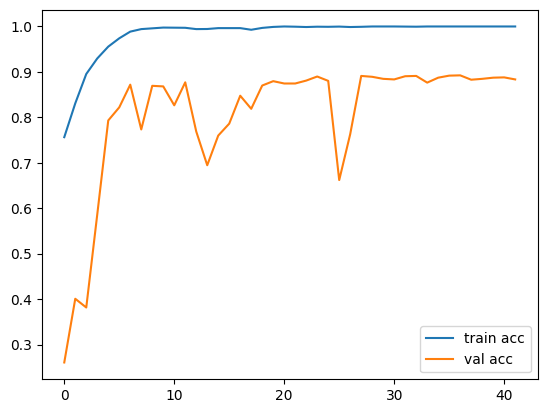

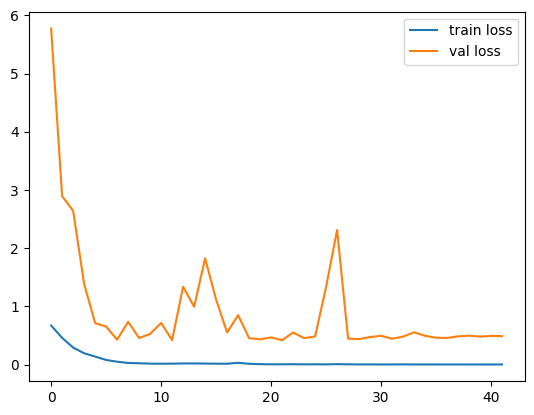

In [11]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

ROC Curve

41/41 [==============================] - 1s 13ms/step


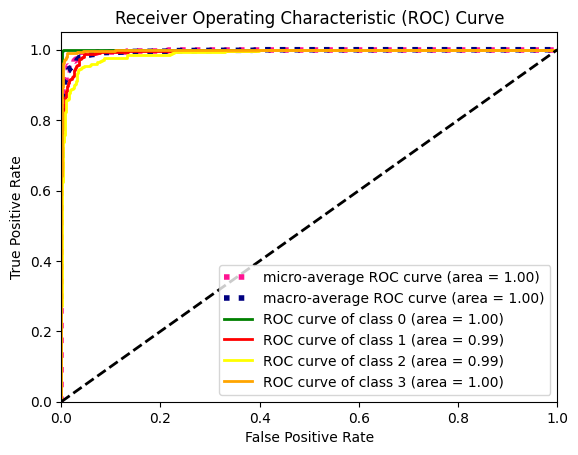

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Przewidywania dla zestawu tesstowego
y_pred = model.predict(x_test)

# Wyznaczanie curve ROC i AUC dla kazdej klasy
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Wyznaczanie krzywej micro-average ROC i ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Oblicza macro-average ROC curve i ROC area
# Zbieranie falszywie pozytywnych przypadkow
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolacja wszystkich krzywych ROC
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Obliczenie pola pod krzywa - AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Wyświetlanie krzywych ROC dla każdej klasy oraz mikro- i makro-średnich na wykresie
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

colors = ['green', 'red', 'yellow', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Zapis modelu do pliku

In [13]:
model.save('trainedModel')

Wczytanie wytrenowanego modelu

In [3]:
tf.keras.models.load_model('trainedModel')

Przewidywania i wizualizacja wyników

In [5]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras import models
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from sklearn import metrics
from tensorflow import keras
import random

def plot_image(i, predictions_array, true_label, img):
  class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

y_pred = model.predict(x_test)
# Wyswietla X losowych zdjec ze zbioru testowego, przewidywania i faktyczne etykiety
# Czerwony kolor wskazuje na miepoprawnie przypisana etykiete, niebieski na poprawna
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  random_num = random.randint(0, 1311)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(random_num, y_pred[random_num], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(random_num, y_pred[random_num],  y_test)
plt.tight_layout()
plt.show()